In [ ]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "www51.polyu.edu.hk"
full_url = "https://www51.polyu.edu.hk"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):

    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []

            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            if 'print' not in clean_link:
              clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("/content/drive/MyDrive/text/"):
            os.mkdir("/content/drive/MyDrive/text/")

    if not os.path.exists("/content/drive/MyDrive/text/"+local_domain+"/"):
            os.mkdir("/content/drive/MyDrive/text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("/content/drive/MyDrive/processed"):
            os.mkdir("/content/drive/MyDrive/processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('/content/drive/MyDrive/text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            for i in range(3):
              try:
                # Get the text from the URL using BeautifulSoup
                soup = BeautifulSoup(requests.get(url).text, "html.parser")
              except RemoteDisconnected as e:
                print(e)
                print(f'Retrying {i+1} times...')
              else:
                break
            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")

            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)
crawl(full_url)

https://www51.polyu.edu.hk
https://www51.polyu.edu.hk/eprospectus/UG
https://www51.polyu.edu.hk/eprospectus/ug/jupas/concurrent-enrolment
https://www51.polyu.edu.hk/eprospectus/ug/non-jupas/faq
https://www51.polyu.edu.hk/javascript:toggle5('contentDivImg13', 'imageDivLink13')
URL can't contain control characters. "/javascript:toggle5('contentDivImg13', 'imageDivLink13')" (found at least ' ')
https://www51.polyu.edu.hk/javascript:toggle5('contentDivImg21', 'imageDivLink21')
URL can't contain control characters. "/javascript:toggle5('contentDivImg21', 'imageDivLink21')" (found at least ' ')
https://www51.polyu.edu.hk/javascript:toggle5('contentDivImg24', 'imageDivLink24')
URL can't contain control characters. "/javascript:toggle5('contentDivImg24', 'imageDivLink24')" (found at least ' ')
https://www51.polyu.edu.hk/javascript:toggle5('contentDivImg3', 'imageDivLink3')
URL can't contain control characters. "/javascript:toggle5('contentDivImg3', 'imageDivLink3')" (found at least ' ')
https:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tiktoken openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 8.4 MB/s eta 0:00:00


In [3]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [ ]:
import os
import pandas as pd

# Create a list to store the text files
texts=[]
domain = "www51.polyu.edu.hk"
# Get all the text files in the text directory
for file in os.listdir("/content/drive/MyDrive/text/" + domain + "/"):

    # Open the file and read the text
    with open("/content/drive/MyDrive/text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('/content/drive/MyDrive/processed/scraped.csv')
df.head()

<ipython-input-3-429202555403>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,.edu.hk,.edu.hk. ﻿ Study@PolyU Search...
1,.edu.hk eprospectus UG,.edu.hk eprospectus UG. ﻿ Study@PolyU ...
2,.edu.hk eprospectus ug jupas concurrent enrolment,.edu.hk eprospectus ug jupas concurrent enrolm...
3,.edu.hk eprospectus ug non jupas faq,.edu.hk eprospectus ug non jupas faq. ﻿ Stu...
4,".edu.hk javascript:toggle5('contentDivImg13', ...",".edu.hk javascript:toggle5('contentDivImg13', ..."


<Axes: >

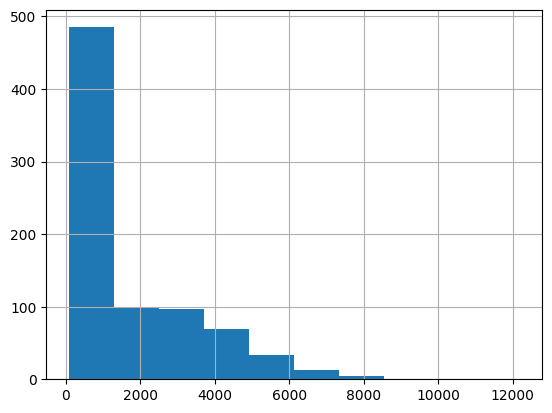

In [ ]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('/content/drive/MyDrive/processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [ ]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

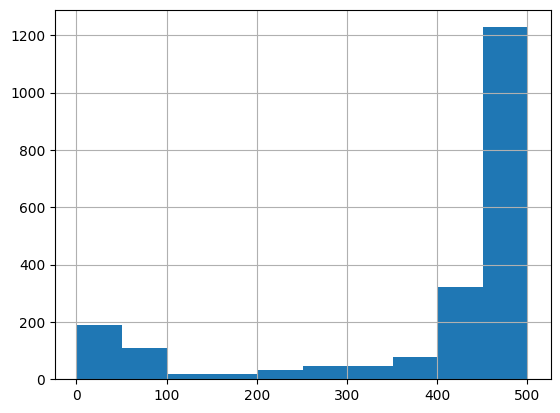

In [ ]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [ ]:
df.head

<bound method NDFrame.head of                                                    text  n_tokens
0     .edu.hk. ﻿   Study@PolyU                Search...       332
1     .edu.hk eprospectus UG. ﻿   Study@PolyU       ...       202
2     .edu.hk eprospectus ug jupas concurrent enrolm...       409
3     .edu.hk eprospectus ug non jupas faq. ﻿    Stu...       500
4     Local and non-local applicants are considered ...       491
...                                                 ...       ...
2085  .edu.hk eprospectus ug non jupas adhd grad pro...       464
2086  edu.hk eprospectus rpg enrolment and registrat...       488
2087  .edu.hk eprospectus ug non jupas programmes se...       473
2088  .edu.hk eprospectus rpg. ﻿   Study@PolyU      ...       334
2089  .edu.hk eprospectus. ﻿   Study@PolyU          ...       336

[2090 rows x 2 columns]>

In [ ]:
import time
import openai
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

openai.api_key = 'your key'

embeddings=[]
for i in range(0, len(df), 5):
  texts = []
  for j in range(5):
    if len(df) > (i + j):
      texts.append(df.iloc[i+j, 0])

  emb = openai.Embedding.create(input=texts, engine='text-embedding-ada-002')

  for j in range(5):
    if len(df) > (i + j):
      embeddings.append(emb['data'][j]['embedding'])
  time.sleep(1)

print(len(embeddings))
df['embeddings']=embeddings
df.to_csv('/content/drive/MyDrive/processed/embeddings.csv')
df.head()

KeyboardInterrupt: ignored

In [4]:
import pandas as pd
import numpy as np
from ast import literal_eval
import openai
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

openai.api_key = 'your key'

df=pd.read_csv('/content/drive/MyDrive/processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(literal_eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,.edu.hk. ﻿ Study@PolyU Search...,332,"[0.008107999339699745, 0.015904651954770088, 0..."
1,.edu.hk eprospectus UG. ﻿ Study@PolyU ...,202,"[0.011299350298941135, 0.016069892793893814, 0..."
2,.edu.hk eprospectus ug jupas concurrent enrolm...,409,"[0.006170344538986683, 0.004535153042525053, 0..."
3,.edu.hk eprospectus ug non jupas faq. ﻿ Stu...,500,"[0.004829402081668377, 0.017824586480855942, 0..."
4,Local and non-local applicants are considered ...,491,"[0.014815696515142918, 0.006413866765797138, 0..."


In [5]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    #model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [6]:
answer_question(df, question="是否接受a-level的中文科目?", debug=False)

'Yes, GCE A-Level E or above is required.'

In [20]:
answer_question(df, question="a-level入学科目限制", debug=False)

"Satisfy the University's General Entrance Requirements. There is no compulsory subject requirement. Preferred subject(s) with the highest weighting for admission score calculation include(s): English Language Mathematics Relevant Applied Learning subject(s) that can be considered for meeting the University entrance requirement and admission score calculation is/are: Accounting in PracticeApplied PsychologyAviation StudiesData Application for Business / Business Data AnalysisEntrepreneurship for SMEEnvironmental EngineeringFood and Beverage OperationsFundamental Health CareHotel OperationsInternet of Everything ApplicationLaw Enforcement in Hong KongMarketing and Online PromotionMarketing in Global TradeMobile and Online Apps DevelopmentNew Media Communication StrategiesPractical PsychologyPurchasing and Merchandising"

In [ ]:
answer_question(df, question="Can I enroll if I am under 18 years old?", debug=False)

'Yes, you can enroll if you are under 18 years old.'

In [ ]:
answer_question(df, question="年龄不到18岁是否可以入学 ?", debug=False)

'Based on the context provided, students under the age of 18 can be admitted to the university, but their parents or guardians must give consent for them to participate in various activities and make decisions related to their studies.'

In [ ]:
answer_question(df, question="What are the computer-related majors?", debug=False)

'The computer-related majors mentioned in the context are Computer Science - BSc (Hons), Enterprise Information Systems - BSc (Hons), and Financial Technology and Artificial Intelligence - BSc (Hons).'

In [ ]:
answer_question(df, question="what is department schema？", debug=False)

'Departmental scheme refers to an admission system where students applying to a university first select a scheme or program within a specific department. Upon enrolling in the university, students undertake common courses within the department during their first academic year. At the end of the first year of study, students have the opportunity to select their major or specialization within their chosen scheme or program, unless specified otherwise by the scheme. This system allows students to explore their interests and aspirations before making a final decision on their major, providing them with more flexible study options.'

In [ ]:
answer_question(df, question="What scholarships does the school offer?", debug=False)

'Based on the context provided, the school offers scholarships and sponsorships for the Overseas Exchange program, Work-Integrated Education, and Service-Learning.'

In [ ]:
answer_question(df, question="大学入学文书有哪些要求? 列出要点", debug=False)

'申请人必须提交一份完整的入学文书，包括：个人基本信息、学术成绩、个人陈述、推荐信、作品集（如果有）、附加文件（如果有）等。'

In [ ]:
answer_question(df, question="What are the entry score requirements for A-levels?", debug=False)

'The 25th–75th percentile of admissions score range for A-levels is 136-168 UCAS Tariff points for 3 AL or 2 AL & 2 AS subjects (including additional points for TOK & EE).'